# Autoencoder + Clustering with daily, 14-days, 21-days mean features

## 1. Abstract
This data analysis aims to detect anomalies by using features that mix daily, short and long term features for each press observation.

The first step is to select the features which are: 
* daily sensor values
* mean from the last 14-days sensor values
* mean from the last 21-days sensor values

Second is to train auto-encoder with these features from which it should hopefuly learn temporal correlations

Third step is to apply clustering to interpret the results from the auto-encoder




## Loading required packages
It is recommended to use library instead of require. If it fails we solve the problem, otherwise it only adds polution to the code.

In [1]:
library(h2o)
library(dplyr)
library(tidyr)
library(ggplot2)

library(repr)

Loading required package: statmod

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Loading training data
Loading the data aggregated daily and with window of means with different sizes. 

The data frame has a _data_ column comprised of list of data frames representing the data for a particular press.

In [2]:
load("data_ps_days_train.dat")
cat("Press Metadata\n")
data_ps_days_train %>% select(-data) %>% glimpse()

Press Metadata
Observations: 716
Variables: 18
$ event_press                  (fctr) 45000586, 45000202, 45000127, 4500018...
$ Product_Line                 (fctr) HP Indigo 7600, HP Indigo 7600, HP In...
$ event_name                   (fctr) SAMPLE_PIP_AND_IMO_PARAMETERS, SAMPLE...
$ series                       (fctr) 7000 Family Sheet Fed Commercial Pres...
$ Region                       (fctr) North America, North America, North A...
$ SubRegion                    (fctr) MidAtlantic United States, Canada, So...
$ District                     (fctr) UNITED STATES, UNITED STATES, UNITED ...
$ Ownership                    (fctr) DIRECT, DIRECT, DIRECT, DIRECT, DIREC...
$ scale_factor_PIP_Temperature (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ scale_factor_IO_temperature  (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ scale_factor_CS_Voltage      (dbl) 1000, 1000, 1000, 1000, 1000, 1000, 10...
$ scale_factor_IO_dirtiness    (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ sca

**Data Dictionary**

* Number of Observations means the number of presses in this data frame
* scale_factor_FEATURE - factor by which to multiply to turn a scaled_FEATURE to the original value.
* events - number of total events for the press
* days - number of days from the first instance to the last instance
* complete - whether the interpolation process was successfully completed. So if we use the interpolated values we do not expect any missing values. _maybe we should rename this to_ successul.interpolation


In [3]:
cat("Press Data\n")
(data_ps_days_train %>% select(data))[[1]][[1]] %>% glimpse()

Press Data
Observations: 117
Variables: 722
$ time_slice                                                 (time) 2016-01...
$ PIP_Temperature_mean                                       (dbl) 289.2857...
$ IO_temperature_mean                                        (dbl) 243.8571...
$ IO_dirtiness_mean                                          (dbl) 825, NA,...
$ CS_Voltage_mean                                            (dbl) 1846, NA...
$ vessel_flow_mean                                           (dbl) 4233.429...
$ scaled_PIP_Temperature_mean                                (dbl) 2.892857...
$ scaled_IO_temperature_mean                                 (dbl) 2.438571...
$ scaled_IO_dirtiness_mean                                   (dbl) 8.25, NA...
$ scaled_CS_Voltage_mean                                     (dbl) 1.846, N...
$ scaled_vessel_flow_mean                                    (dbl) 4.233429...
$ PIP_Temperature_median                                     (dbl) 292, NA,...
$ IO_tem

**Data Dictionary**


* Number of Observations means the number of events for the first press, which share the structure with the rest of the presses in the overall data frame.

* interp - means the values have been interpolated to add data where the press didn't have values for that day, after computing the aggregation function.

* event_slice_count - number of actual events for the press on that particular day. A 0 would mean no events found to aggregate.

* scaled - means the values have been scaled using the scaled factor before the aggregation

* FEATURE_FUN - FUN is the aggregation used. One of "mean, median, sd, IQR, max, min".

* width_N_mean_FEATURE_FUN - represents mean over a window of N days from the current day to the past

* shift_M_width_N_FEATURE_FUN - represents mean over a window of N days from a day M days in the past. Or a window that has been shifted forward by M days.

## Loading test data
Loading the data aggregated daily and with window of means with different sizes. 

The data frame has a _data_ column comprised of list of data frames representing the data for a particular press. Same as the training data.

In [4]:
load("data_ps_days_test.dat")
cat("Press Metadata\n")
data_ps_days_train %>% select(-data) %>% glimpse()

Press Metadata
Observations: 716
Variables: 18
$ event_press                  (fctr) 45000586, 45000202, 45000127, 4500018...
$ Product_Line                 (fctr) HP Indigo 7600, HP Indigo 7600, HP In...
$ event_name                   (fctr) SAMPLE_PIP_AND_IMO_PARAMETERS, SAMPLE...
$ series                       (fctr) 7000 Family Sheet Fed Commercial Pres...
$ Region                       (fctr) North America, North America, North A...
$ SubRegion                    (fctr) MidAtlantic United States, Canada, So...
$ District                     (fctr) UNITED STATES, UNITED STATES, UNITED ...
$ Ownership                    (fctr) DIRECT, DIRECT, DIRECT, DIRECT, DIREC...
$ scale_factor_PIP_Temperature (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ scale_factor_IO_temperature  (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ scale_factor_CS_Voltage      (dbl) 1000, 1000, 1000, 1000, 1000, 1000, 10...
$ scale_factor_IO_dirtiness    (dbl) 100, 100, 100, 100, 100, 100, 100, 100...
$ sca

In [5]:
cat("Press Data\n")
(data_ps_days_train %>% select(data))[[1]][[1]] %>% glimpse()

Press Data
Observations: 117
Variables: 722
$ time_slice                                                 (time) 2016-01...
$ PIP_Temperature_mean                                       (dbl) 289.2857...
$ IO_temperature_mean                                        (dbl) 243.8571...
$ IO_dirtiness_mean                                          (dbl) 825, NA,...
$ CS_Voltage_mean                                            (dbl) 1846, NA...
$ vessel_flow_mean                                           (dbl) 4233.429...
$ scaled_PIP_Temperature_mean                                (dbl) 2.892857...
$ scaled_IO_temperature_mean                                 (dbl) 2.438571...
$ scaled_IO_dirtiness_mean                                   (dbl) 8.25, NA...
$ scaled_CS_Voltage_mean                                     (dbl) 1.846, N...
$ scaled_vessel_flow_mean                                    (dbl) 4.233429...
$ PIP_Temperature_median                                     (dbl) 292, NA,...
$ IO_tem

## Loading H2O

In [6]:
seed <- 100
set.seed(seed)

h2o.init(ip = "15.8.169.215", port = 54321, startH2O = F)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         34 days 3 minutes 
    H2O cluster version:        3.8.3.4 
    H2O cluster name:           root 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.37 GB 
    H2O cluster total cores:    32 
    H2O cluster allowed cores:  32 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          15.8.169.215 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 



## Select features to be evaluated

According to Augusto we should do a few things prior to presenting this data to the AutoEncoder:

* Remove "obvious" anomalies. In this case, maybe we should remove the entries with 0 as a value, where previous analyses showed it not to be common.
* Use number of events used to calculate the value for the day as a feature.
* Calculate the mean for previous weeks, perhaps 3.
    - This might mean increasing the width of the window from 7, to 14 and then 21 days,
    - Or, it might mean to shift a 7 days window by a step of 7 days 2 times
* Remove events where missing data is present (A limitation of the AutoEncoder)
* Use the first 4 months as training data

The training data set we loaded was created using the first 4 months of entire dataset, and includes columns for number of events (events_slice_count) and both windowing strategies. We'll need to filter out days with 0 and missing values.

It was not mentioned, but having the values for the neural net have more or less the same scale is important. So in this attempt we'll choose the "scaled" features of the dataset eschewing the both the original and the interpolated values.


### Training events for all product lines

In this first attempt we do not separate the training data into specific model so the neural net has more date to learn from.

In [7]:
training_data <- data_ps_days_train %>% unnest() %>%
    #filter entries where one of these features are 0
    filter(scaled_PIP_Temperature_mean != 0 &
           scaled_IO_temperature_mean != 0 &
           scaled_CS_Voltage_mean != 0 &
           scaled_vessel_flow_mean != 0) %>%
    #select only the scaled values aggregated with 'mean, median, min, max, sd and IQR'
    select(event_press, time_slice, Product_Line, events, days, event_slice_count,
           ends_with("_mean"), ends_with("_median"), ends_with("_min"), ends_with("_max"),
           ends_with("_sd"), ends_with("_IQR"), -contains("interp")) %>%
    select(event_press, time_slice, Product_Line, events, days, event_slice_count, contains("scaled")) %>%
    #remove entries with missing values
    na.omit() 

cat("All observations: ", data_ps_days_train %>% unnest() %>% nrow(), "\n")
training_data %>% glimpse()

All observations:  79449 
Observations: 10,718
Variables: 186
$ event_press                                         (fctr) 45000586, 4500...
$ time_slice                                          (time) 2016-01-26, 20...
$ Product_Line                                        (fctr) HP Indigo 7600...
$ events                                              (dbl) 72, 72, 216, 21...
$ days                                                (int) 117, 117, 111, ...
$ event_slice_count                                   (dbl) 3, 4, 4, 3, 2, ...
$ scaled_PIP_Temperature_mean                         (dbl) 2.680000, 2.857...
$ scaled_IO_temperature_mean                          (dbl) 2.386667, 2.492...
$ scaled_IO_dirtiness_mean                            (dbl) 8.25, 8.25, 9.8...
$ scaled_CS_Voltage_mean                              (dbl) 1.846, 1.846, 1...
$ scaled_vessel_flow_mean                             (dbl) 4.074000, 4.189...
$ width_7_mean_scaled_PIP_Temperature_mean            (dbl) 2.655000,

In [8]:
training_data %>% group_by(event_press) %>%
                  summarise(n_events = n()) %>% 
                  summarise(n_presses = n(), n_events = sum(n_events))
training_data %>% group_by(Product_Line, event_press) %>%
                  summarise(n_events = n()) %>% 
                  summarise(n_presses = n(), n_events = sum(n_events))

n_presses n_events
1       506    10718

Product_Line n_presses n_events
1 HP Indigo 7000       126     2320
2 HP Indigo 7500       137     2861
3 HP Indigo 7600       243     5537

HP Indigo 7600 are represented more on the training data. This might affect the generalization, so we'll make note of this here. We'll also verify if there is any bias seen on the anomaly score as a result of this.

In [9]:
test_data <- data_ps_days_test %>% unnest() %>%
    #filter entries where one of these features are 0
    filter(scaled_PIP_Temperature_mean != 0 &
           scaled_IO_temperature_mean != 0 &
           scaled_CS_Voltage_mean != 0 &
           scaled_vessel_flow_mean != 0) %>%
    #select only the scaled values aggregated with 'mean, median, min, max, sd and IQR'
    select(event_press, time_slice, Product_Line, events, days, event_slice_count,
           ends_with("_mean"), ends_with("_median"), ends_with("_min"), ends_with("_max"),
           ends_with("_sd"), ends_with("_IQR"), -contains("interp")) %>%
    select(event_press, time_slice, Product_Line, events, days, event_slice_count, contains("scaled")) %>%
    #remove entries with missing values
    na.omit() 

cat("All observations: ", data_ps_days_test %>% unnest() %>% nrow(), "\n")
test_data %>% glimpse()

All observations:  38278 
Observations: 4,489
Variables: 186
$ event_press                                         (fctr) 45000586, 4500...
$ time_slice                                          (time) 2016-05-27, 20...
$ Product_Line                                        (fctr) HP Indigo 7600...
$ events                                              (dbl) 58, 58, 58, 58,...
$ days                                                (int) 61, 61, 61, 61,...
$ event_slice_count                                   (dbl) 3, 2, 3, 2, 3, ...
$ scaled_PIP_Temperature_mean                         (dbl) 3.013333, 2.785...
$ scaled_IO_temperature_mean                          (dbl) 2.466667, 2.480...
$ scaled_IO_dirtiness_mean                            (dbl) 8.25, 8.25, 8.2...
$ scaled_CS_Voltage_mean                              (dbl) 1.846, 1.846, 1...
$ scaled_vessel_flow_mean                             (dbl) 4.106000, 4.164...
$ width_7_mean_scaled_PIP_Temperature_mean            (dbl) 2.880833, 

In [10]:
test_data %>% group_by(event_press) %>%
                  summarise(n_events = n()) %>% 
                  summarise(n_presses = n(), n_events = sum(n_events))
test_data %>% group_by(Product_Line, event_press) %>%
                  summarise(n_events = n()) %>% 
                  summarise(n_presses = n(), n_events = sum(n_events))

n_presses n_events
1       412     4489

Product_Line n_presses n_events
1 HP Indigo 7000        89      943
2 HP Indigo 7500       116     1219
3 HP Indigo 7600       207     2327

#### Preparing Data for H2O
Before training can be done we need to transform the data frame to the H2O equivalent. That format does not support POSIXct so we remove the time_slice column which will not be used anyways.

In [11]:
h2o_train <- as.h2o(select(training_data, -time_slice))
glimpse(h2o_train)

  |======================================================================| 100%
Observations: 10,718
Variables: 185
$ event_press                                         (fctr) 45000586, 4500...
$ Product_Line                                        (fctr) HP Indigo 7600...
$ events                                              (dbl) 72, 72, 216, 21...
$ days                                                (dbl) 117, 117, 111, ...
$ event_slice_count                                   (dbl) 3, 4, 4, 3, 2, 29
$ scaled_PIP_Temperature_mean                         (dbl) 2.680000, 2.857...
$ scaled_IO_temperature_mean                          (dbl) 2.386667, 2.492...
$ scaled_IO_dirtiness_mean                            (dbl) 8.25, 8.25, 9.8...
$ scaled_CS_Voltage_mean                              (dbl) 1.846, 1.846, 1...
$ scaled_vessel_flow_mean                             (dbl) 4.07400, 4.1895...
$ width_7_mean_scaled_PIP_Temperature_mean            (dbl) 2.655000, 2.836...
$ width_7_mean_s

In [12]:
h2o_test <- as.h2o(select(test_data, -time_slice))
glimpse(h2o_test)

  |======================================================================| 100%
Observations: 4,489
Variables: 185
$ event_press                                         (fctr) 45000586, 4500...
$ Product_Line                                        (fctr) HP Indigo 7600...
$ events                                              (dbl) 58, 58, 58, 58,...
$ days                                                (dbl) 61, 61, 61, 61,...
$ event_slice_count                                   (dbl) 3, 2, 3, 2, 3, 6
$ scaled_PIP_Temperature_mean                         (dbl) 3.013333, 2.785...
$ scaled_IO_temperature_mean                          (dbl) 2.466667, 2.480...
$ scaled_IO_dirtiness_mean                            (dbl) 8.25, 8.25, 8.2...
$ scaled_CS_Voltage_mean                              (dbl) 1.846, 1.846, 1...
$ scaled_vessel_flow_mean                             (dbl) 4.106, 4.164, 4...
$ width_7_mean_scaled_PIP_Temperature_mean            (dbl) 2.880833, 2.785...
$ width_7_mean_sca

#### Training Using Autoencoder

For training we do not consider these columns:
- event_press
- Product_Line
- events
- days

In [13]:
h2o_model <- h2o.deeplearning(
    x = 5:185, 
    training_frame = h2o_train,  # data is automatically normalized by h2o with range(-0.5, 0.5)
    autoencoder = TRUE, 
    hidden = c(30, 10, 30), #c(20, 10, 20),  #c(10, 30, 50, 30, 10), #read documentation to know what it means 
    activation = "Tanh", # default activation for autoencoder
    epochs = 5,
    seed = seed) #Setting a seed value for reproducibility purposes

  |======================================================================| 100%


In [14]:
anom_scores_train <- h2o.anomaly(h2o_model, h2o_train)
anom_scores_test <- h2o.anomaly(h2o_model, h2o_test)
anom_scores_train %>% glimpse()
anom_scores_test %>% glimpse()

Observations: 10,718
Variables: 1
$ Reconstruction.MSE (dbl) 0.009438897, 0.007705632, 0.014012744, 0.0141250...
Observations: 4,489
Variables: 1
$ Reconstruction.MSE (dbl) 0.006267938, 0.006632684, 0.006768674, 0.0392789...


In [15]:
anom_scores_per_feature_train <- h2o.anomaly(h2o_model, h2o_train, per_feature = T)
anom_scores_per_feature_test <- h2o.anomaly(h2o_model, h2o_test, per_feature = T)
anom_scores_per_feature_train %>% glimpse()
anom_scores_per_feature_test %>% glimpse()

Observations: 10,718
Variables: 181
$ reconstr_event_slice_count.SE                                   (dbl) 0.0...
$ reconstr_scaled_PIP_Temperature_mean.SE                         (dbl) 1.4...
$ reconstr_scaled_IO_temperature_mean.SE                          (dbl) 6.4...
$ reconstr_scaled_IO_dirtiness_mean.SE                            (dbl) 0.0...
$ reconstr_scaled_CS_Voltage_mean.SE                              (dbl) 0.0...
$ reconstr_scaled_vessel_flow_mean.SE                             (dbl) 0.0...
$ reconstr_width_7_mean_scaled_PIP_Temperature_mean.SE            (dbl) 0.0...
$ reconstr_width_7_mean_scaled_IO_temperature_mean.SE             (dbl) 0.0...
$ reconstr_width_7_mean_scaled_IO_dirtiness_mean.SE               (dbl) 0.0...
$ reconstr_width_7_mean_scaled_CS_Voltage_mean.SE                 (dbl) 0.0...
$ reconstr_width_7_mean_scaled_vessel_flow_mean.SE                (dbl) 0.0...
$ reconstr_width_14_mean_scaled_PIP_Temperature_mean.SE           (dbl) 0.0...
$ reconstr_width

In [16]:
anom_scores_data_train <- anom_scores_per_feature_train %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_train))

anom_scores_data_train %>% glimpse()

anom_scores_data_test <- anom_scores_per_feature_test %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_test))

anom_scores_data_test %>% glimpse()

Observations: 10,718
Variables: 182
$ reconstr_event_slice_count.SE                                   (dbl) 2.7...
$ reconstr_scaled_PIP_Temperature_mean.SE                         (dbl) 1.4...
$ reconstr_scaled_IO_temperature_mean.SE                          (dbl) 6.4...
$ reconstr_scaled_IO_dirtiness_mean.SE                            (dbl) 0.0...
$ reconstr_scaled_CS_Voltage_mean.SE                              (dbl) 0.0...
$ reconstr_scaled_vessel_flow_mean.SE                             (dbl) 0.0...
$ reconstr_width_7_mean_scaled_PIP_Temperature_mean.SE            (dbl) 0.0...
$ reconstr_width_7_mean_scaled_IO_temperature_mean.SE             (dbl) 0.0...
$ reconstr_width_7_mean_scaled_IO_dirtiness_mean.SE               (dbl) 0.0...
$ reconstr_width_7_mean_scaled_CS_Voltage_mean.SE                 (dbl) 0.0...
$ reconstr_width_7_mean_scaled_vessel_flow_mean.SE                (dbl) 9.1...
$ reconstr_width_14_mean_scaled_PIP_Temperature_mean.SE           (dbl) 1.5...
$ reconstr_width

In [17]:
training_anom <- cbind(training_data, anom_scores_data_train) %>%
                 arrange(desc(Reconstruction.MSE))

training_anom %>% glimpse()

test_anom <- cbind(test_data, anom_scores_data_test) %>%
                 arrange(desc(Reconstruction.MSE))

test_anom %>% glimpse()

Observations: 10,718
Variables: 368
$ event_press                                                     (fctr) 40...
$ time_slice                                                      (time) 20...
$ Product_Line                                                    (fctr) HP...
$ events                                                          (dbl) 120...
$ days                                                            (int) 120...
$ event_slice_count                                               (dbl) 11,...
$ scaled_PIP_Temperature_mean                                     (dbl) 2.9...
$ scaled_IO_temperature_mean                                      (dbl) 1.5...
$ scaled_IO_dirtiness_mean                                        (dbl) 4.7...
$ scaled_CS_Voltage_mean                                          (dbl) 1.0...
$ scaled_vessel_flow_mean                                         (dbl) 4.2...
$ width_7_mean_scaled_PIP_Temperature_mean                        (dbl) 2.9...
$ width_7_mean_s

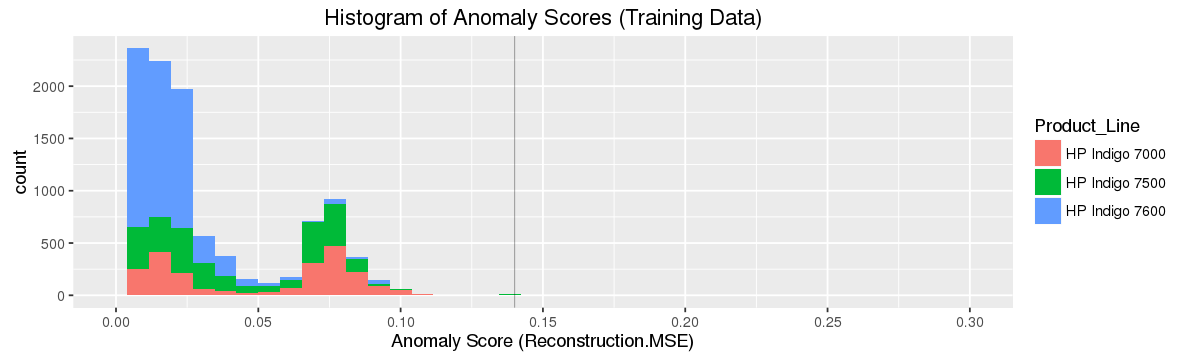

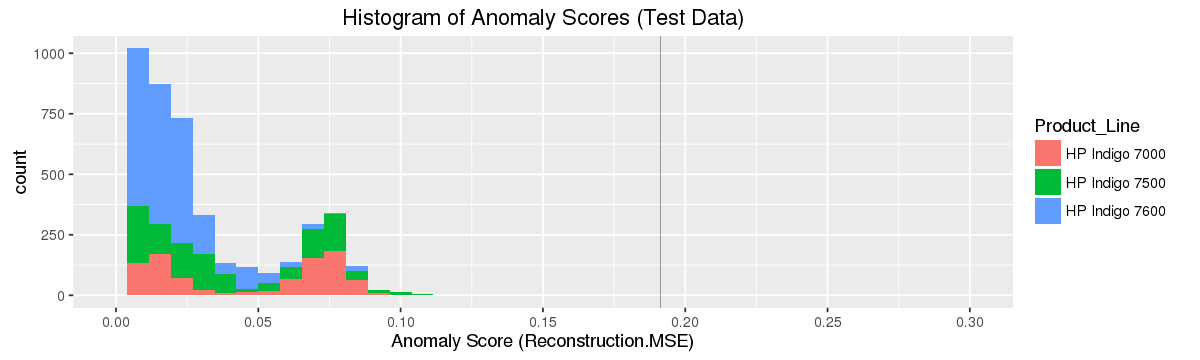

In [64]:
options(repr.plot.width=10, repr.plot.height = 3)
training_anom %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  ggtitle("Histogram of Anomaly Scores (Training Data)") +
                  xlab("Anomaly Score (Reconstruction.MSE)") +
                  scale_x_continuous(breaks = seq(0, 1, 0.05), limits = c(0,0.3)) +
                  geom_vline(xintercept = max(training_anom$Reconstruction.MSE), size = 0.1)
                  

test_anom %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  ggtitle("Histogram of Anomaly Scores (Test Data)") +
                  xlab("Anomaly Score (Reconstruction.MSE)") +
                  scale_x_continuous(breaks = seq(0, 1, 0.05), limits = c(0,0.3)) +
                  geom_vline(xintercept = max(test_anom$Reconstruction.MSE), size = 0.1)

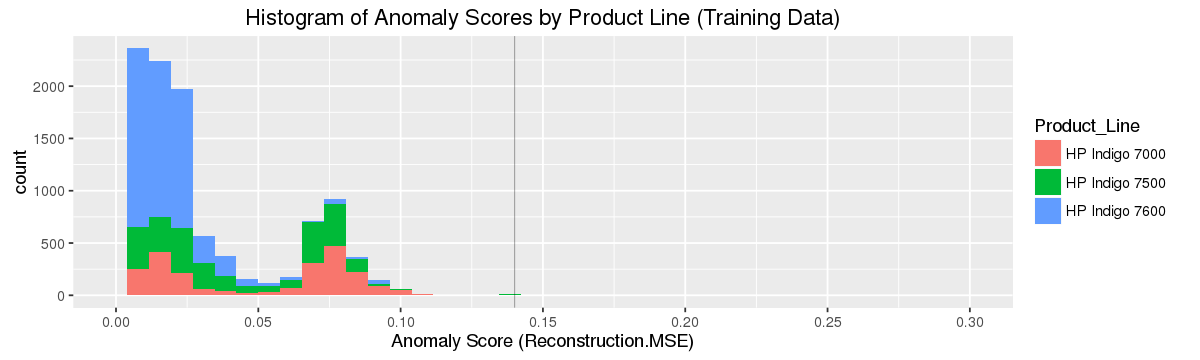

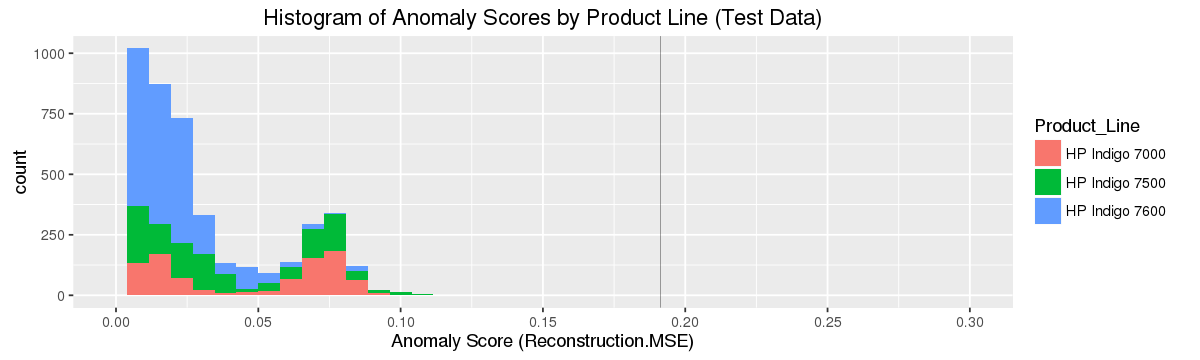

In [67]:
options(repr.plot.width=10, repr.plot.height = 3)
training_anom %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  ggtitle("Histogram of Anomaly Scores by Product Line (Training Data)") +
                  xlab("Anomaly Score (Reconstruction.MSE)") +
                  scale_x_continuous(breaks = seq(0, 1, 0.05), limits = c(0,0.3)) +
                  geom_vline(xintercept = max(training_anom$Reconstruction.MSE), size = 0.1)

test_anom %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  ggtitle("Histogram of Anomaly Scores by Product Line (Test Data)") +
                  xlab("Anomaly Score (Reconstruction.MSE)") +
                  scale_x_continuous(breaks = seq(0, 1, 0.05), limits = c(0,0.3)) +
                  geom_vline(xintercept = max(test_anom$Reconstruction.MSE), size = 0.1)

In [20]:
display_data_train <- training_anom %>% select(event_press, Product_Line, starts_with("reconstr_scaled_")) %>%
                  gather(key = Feature, value = Value, -event_press, -Product_Line) %>%
                  mutate(Feature = gsub("_mean.SE", ".mean_SE", Feature)) %>%
                  mutate(Feature = gsub("_median.SE", ".median_SE", Feature)) %>%
                  mutate(Feature = gsub("_min.SE", ".min_SE", Feature)) %>%
                  mutate(Feature = gsub("_max.SE", ".max_SE", Feature)) %>%
                  mutate(Feature = gsub("_IQR.SE", ".IQR_SE", Feature)) %>%
                  mutate(Feature = gsub("_sd.SE", ".sd_SE", Feature)) %>%
                  separate(Feature, c("Feature", "Method"), "[[.]]")

display_data_test <- test_anom %>% select(event_press, Product_Line, starts_with("reconstr_scaled_")) %>%
                  gather(key = Feature, value = Value, -event_press, -Product_Line) %>%
                  mutate(Feature = gsub("_mean.SE", ".mean_SE", Feature)) %>%
                  mutate(Feature = gsub("_median.SE", ".median_SE", Feature)) %>%
                  mutate(Feature = gsub("_min.SE", ".min_SE", Feature)) %>%
                  mutate(Feature = gsub("_max.SE", ".max_SE", Feature)) %>%
                  mutate(Feature = gsub("_IQR.SE", ".IQR_SE", Feature)) %>%
                  mutate(Feature = gsub("_sd.SE", ".sd_SE", Feature)) %>%
                  separate(Feature, c("Feature", "Method"), "[[.]]")

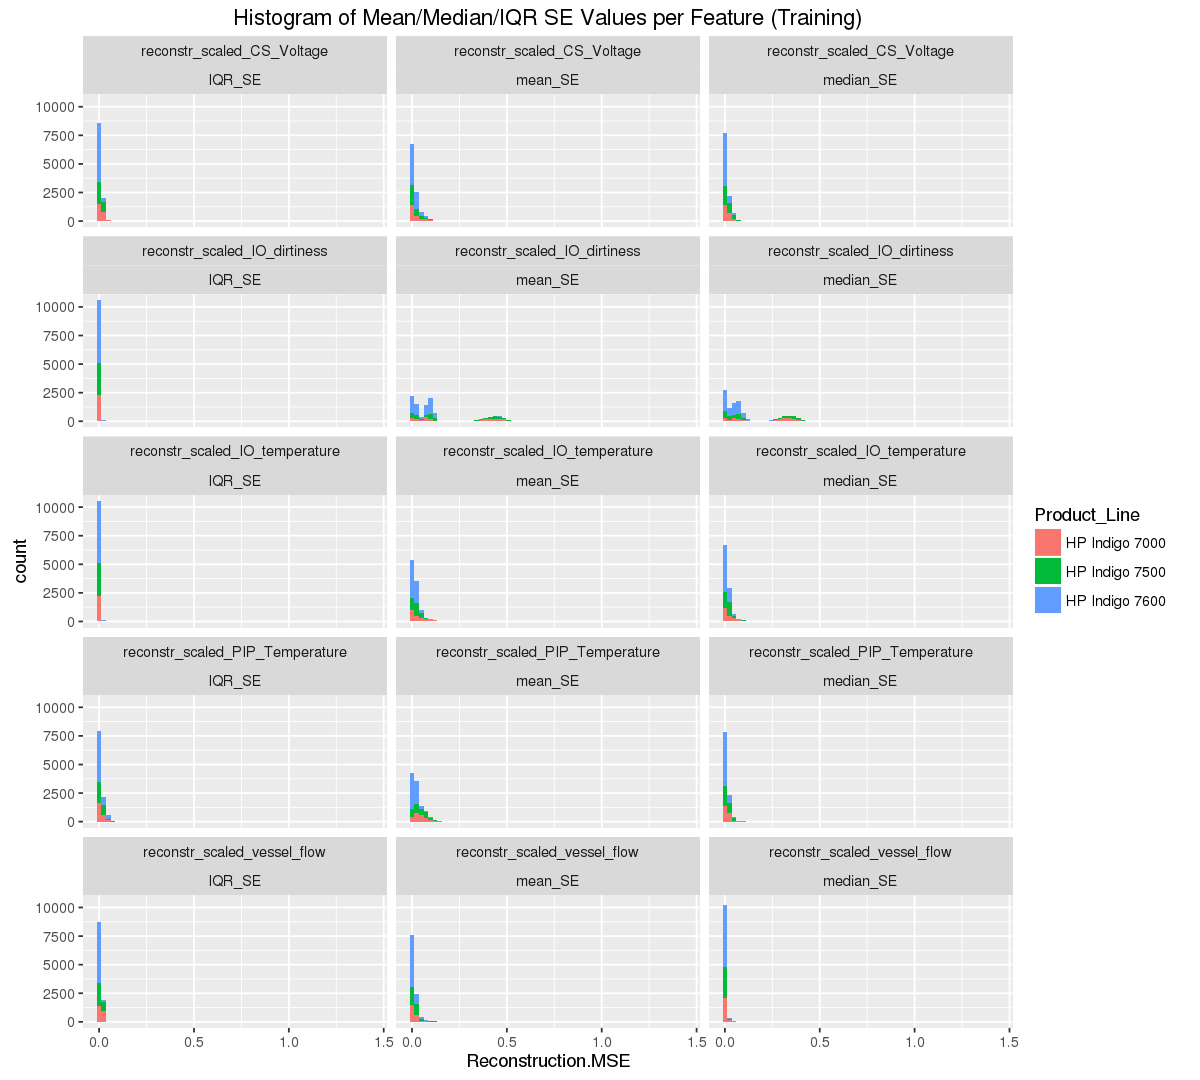

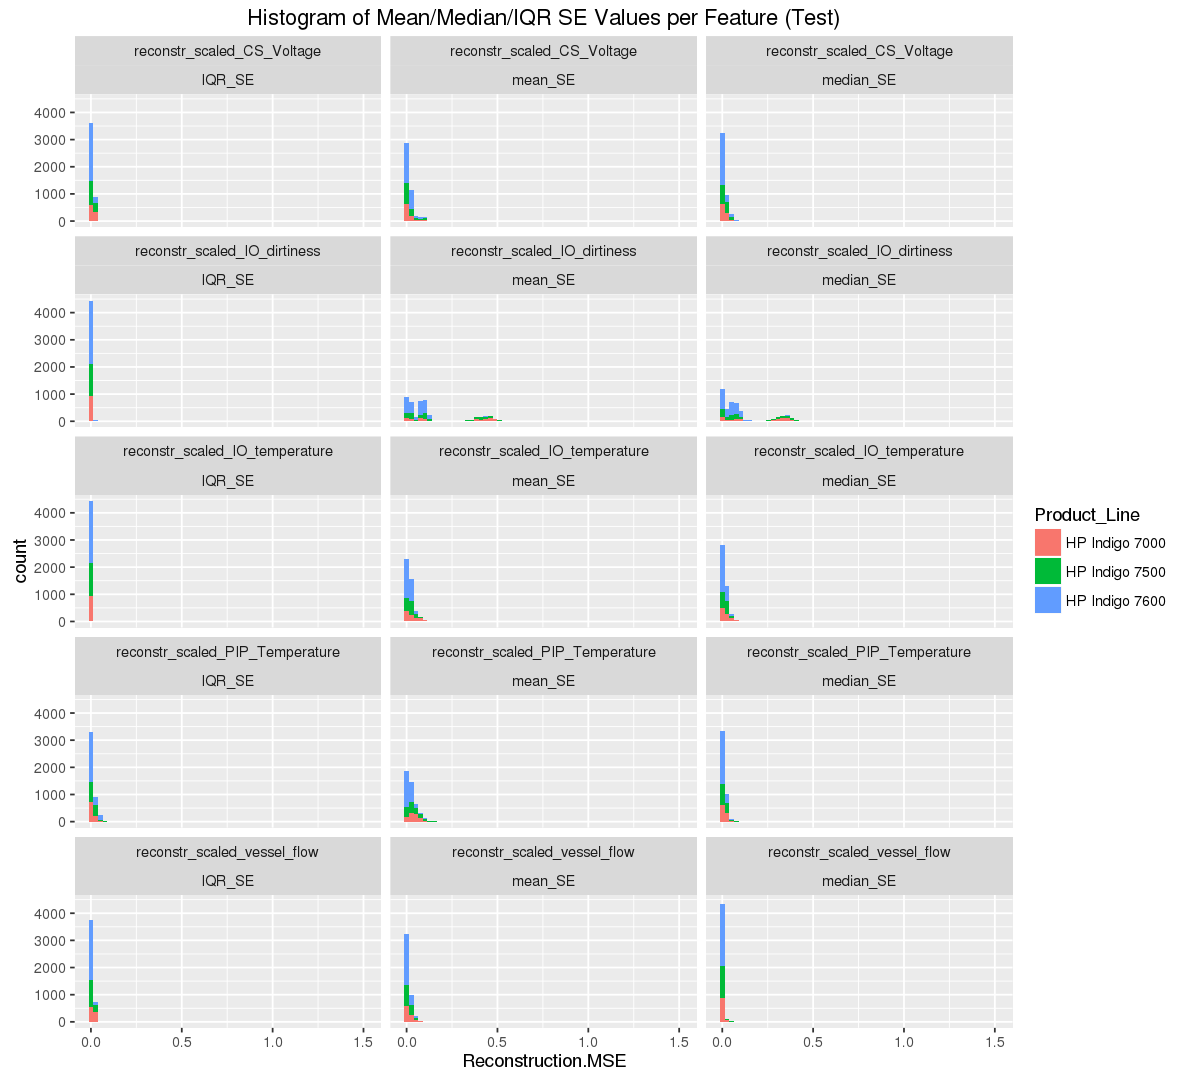

In [70]:
options(repr.plot.width=10, repr.plot.height = 9)
display_data_train %>% filter(Method == "mean_SE" | Method == "median_SE" | Method == "IQR_SE") %>%
                 ggplot(aes(x = Value, fill = Product_Line)) +
                 geom_histogram(bins = 60) +
                 facet_wrap(~Feature + Method, nrow = 5, ncol = 3) +
                 ggtitle("Histogram of Mean/Median/IQR SE Values per Feature (Training)") +
                 xlab("Reconstruction.MSE")

display_data_test %>% filter(Method == "mean_SE" | Method == "median_SE" | Method == "IQR_SE") %>%
                 ggplot(aes(x = Value, fill = Product_Line)) +
                 geom_histogram(bins = 60) +
                 facet_wrap(~Feature + Method, nrow = 5, ncol = 3) +
                 ggtitle("Histogram of Mean/Median/IQR SE Values per Feature (Test)") +
                 xlab("Reconstruction.MSE")

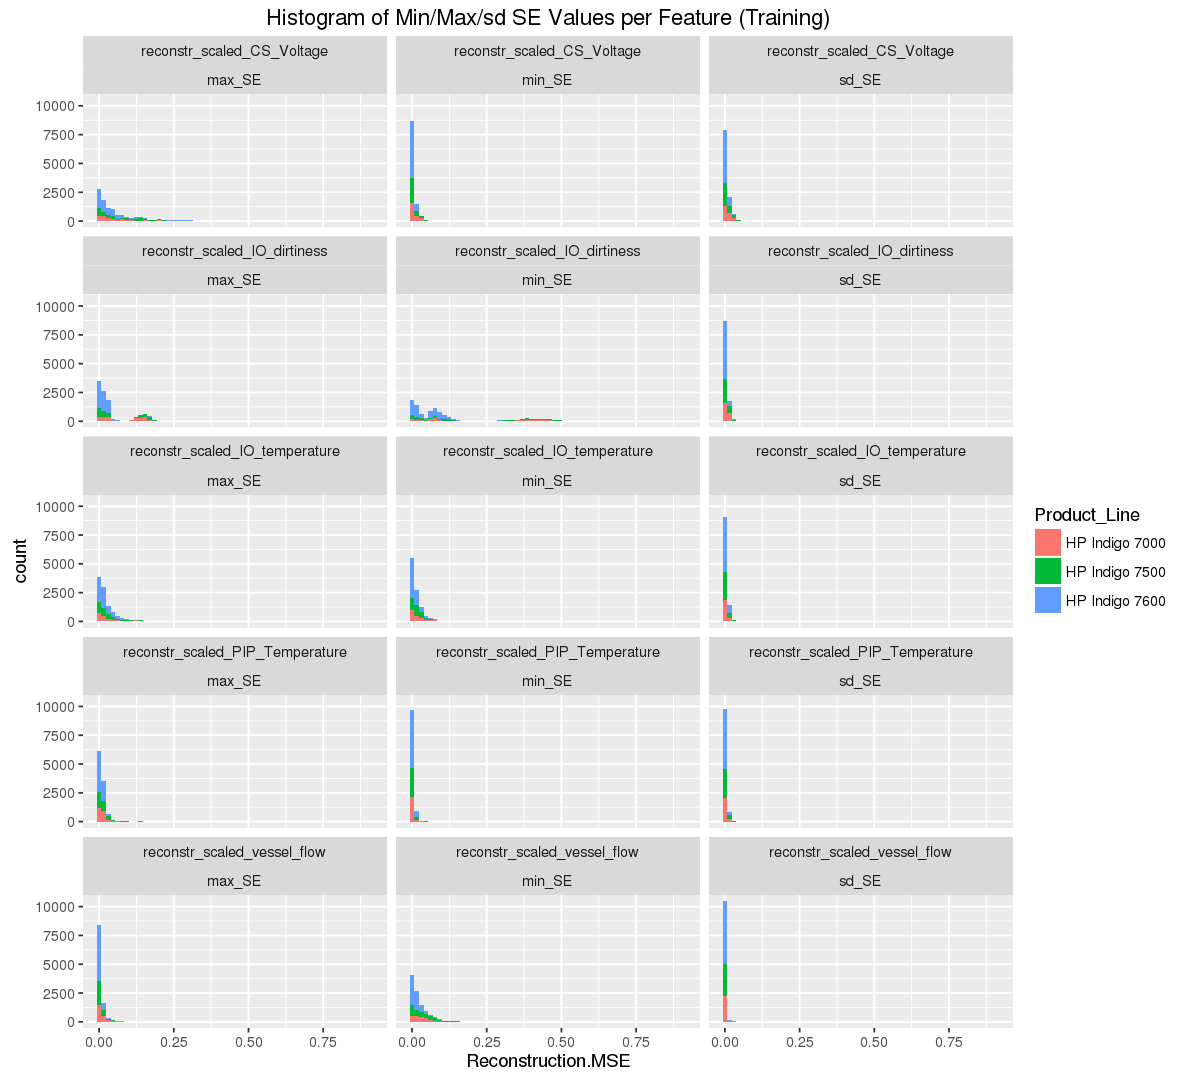

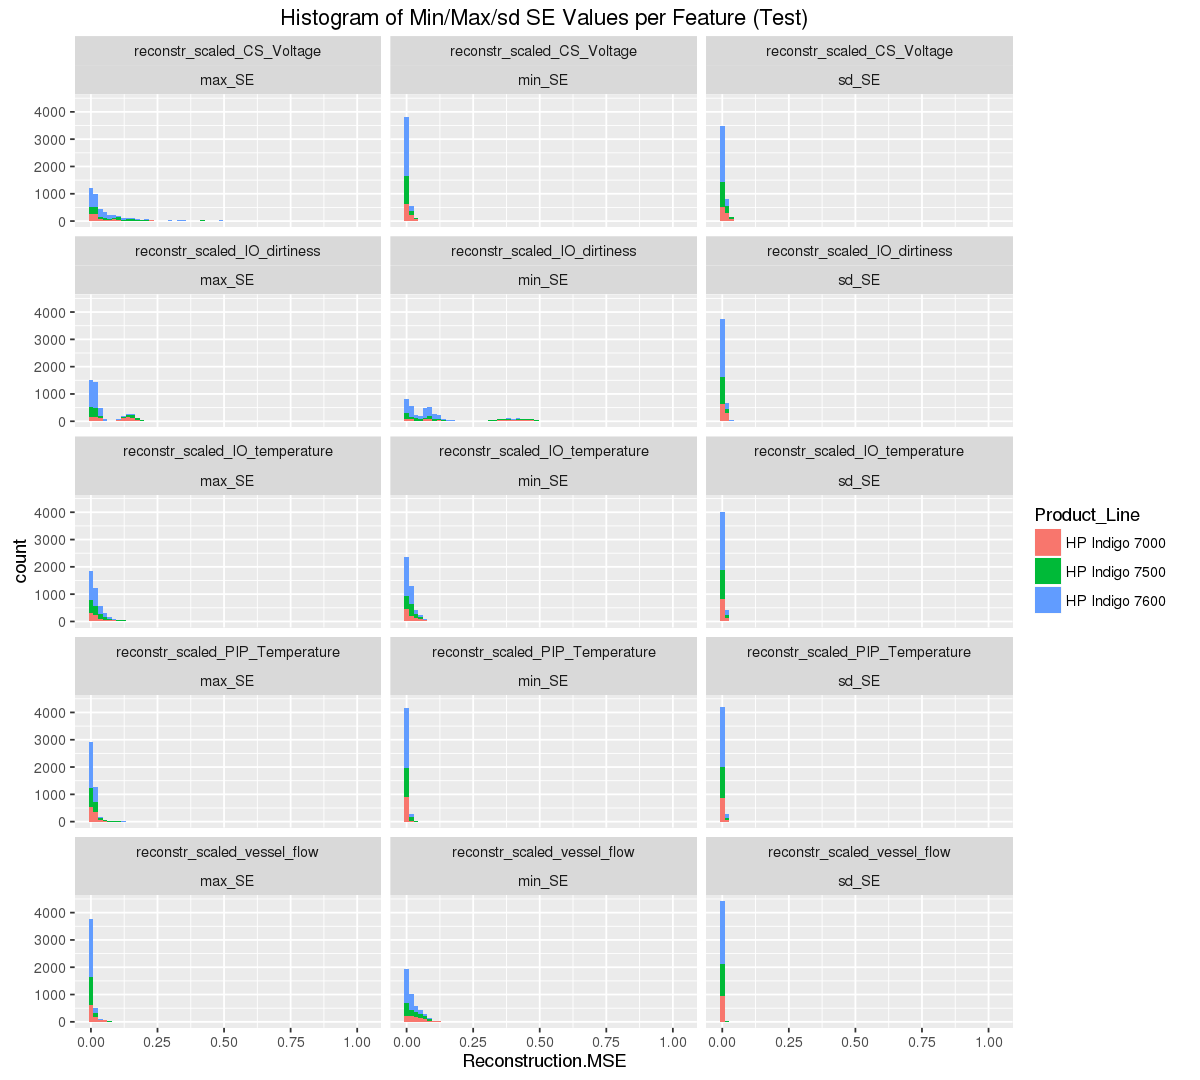

In [71]:
options(repr.plot.width=10, repr.plot.height = 9)
display_data_train %>% filter(Method == "min_SE" | Method == "max_SE" | Method == "sd_SE") %>%
                 ggplot(aes(x = Value, fill = Product_Line)) +
                 geom_histogram(bins = 60) +
                 facet_wrap(~Feature + Method, nrow = 5, ncol = 3) +
                 ggtitle("Histogram of Min/Max/sd SE Values per Feature (Training)") +
                 xlab("Reconstruction.MSE")

display_data_test %>% filter(Method == "min_SE" | Method == "max_SE" | Method == "sd_SE") %>%
                 ggplot(aes(x = Value, fill = Product_Line)) +
                 geom_histogram(bins = 60) +
                 facet_wrap(~Feature + Method, nrow = 5, ncol = 3) +
                 ggtitle("Histogram of Min/Max/sd SE Values per Feature (Test)") +
                 xlab("Reconstruction.MSE")

In [46]:
cat("Training data\n")
training_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom)) %>% 
                  summarise(n_presses = n(),
                            max_anom = max(max_anom),
                            min_anom = min(min_anom),
                            range_anom = max_anom - min_anom,
                            events = sum(n_events))

training_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom)) %>% 
                  summarise(n_presses = n(),
                            max_anom = max(max_anom),
                            min_anom = min(min_anom),
                            range_anom = max_anom - min_anom,
                            events = sum(n_events))
cat("Testing data\n")
test_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom)) %>% 
                  summarise(n_presses = n(),
                            max_anom = max(max_anom),
                            min_anom = min(min_anom),
                            range_anom = max_anom - min_anom,
                            events = sum(n_events))

test_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom)) %>% 
                  summarise(n_presses = n(),
                            max_anom = max(max_anom),
                            min_anom = min(min_anom),
                            range_anom = max_anom - min_anom,
                            events = sum(n_events))

Training data


n_presses max_anom min_anom range_anom events
1       506   0.1401    8e-04     0.1393  10718

n_presses max_anom min_anom range_anom events
1        91   0.1401   0.0764     0.0637   1071

Testing data


n_presses max_anom min_anom range_anom events
1       412   0.1913    8e-04     0.1905   4489

n_presses max_anom min_anom range_anom events
1        65   0.1913   0.0739     0.1174    448

We see that 90 out 506 presses contain the 10% most anomalous events found by the AutoEncoder training (1071 out of 10718). The range of anomaly scores is for the 10% most anomalous events is 0.3973, while considering all events we don't see a great difference in range. This means there may be very few "highly" anomalous results, which we already suspected based on the histogram.

In [28]:
cat("Training data\n")
training_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))
training_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))

cat("Testing data\n")
test_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))
test_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))

Training data


Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7000   0.1401   0.0019    0.0493      0.0651  0.0318     2320
2 HP Indigo 7500   0.1400   0.0013    0.0407      0.0312  0.0287     2861
3 HP Indigo 7600   0.0951   0.0008    0.0179      0.0166  0.0140     5537

Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7000   0.1401   0.0764    0.0852      0.0830  0.0077      578
2 HP Indigo 7500   0.1400   0.0764    0.0831      0.0798  0.0111      401
3 HP Indigo 7600   0.0951   0.0767    0.0863      0.0876  0.0059       92

Testing data


Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7500   0.1913   0.0012    0.0384      0.0304  0.0284     1219
2 HP Indigo 7000   0.1135   0.0014    0.0462      0.0619  0.0300      943
3 HP Indigo 7600   0.0885   0.0008    0.0188      0.0165  0.0146     2327

Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7500   0.1913   0.0739    0.0827      0.0786  0.0129      197
2 HP Indigo 7000   0.1135   0.0739    0.0797      0.0784  0.0054      227
3 HP Indigo 7600   0.0885   0.0739    0.0842      0.0842  0.0033       24

### Training events for product lines separatedly

This time we'll separate the events into different training sets based on Product line.

In [29]:
training_data_7000 <- training_data %>% filter(Product_Line == "HP Indigo 7000")
training_data_7500 <- training_data %>% filter(Product_Line == "HP Indigo 7500")
training_data_7600 <- training_data %>% filter(Product_Line == "HP Indigo 7600")

test_data_7000 <- test_data %>% filter(Product_Line == "HP Indigo 7000")
test_data_7500 <- test_data %>% filter(Product_Line == "HP Indigo 7500")
test_data_7600 <- test_data %>% filter(Product_Line == "HP Indigo 7600")

#### Preparing Training Data for H2O
Before training can be done we need to transform the data frame to the H2O equivalent. That format does not support POSIXct so we remove the time_slice column which will not be used anyways.

In [30]:
h2o_train_7000 <- as.h2o(select(training_data_7000, -time_slice))
h2o_train_7500 <- as.h2o(select(training_data_7500, -time_slice))
h2o_train_7600 <- as.h2o(select(training_data_7600, -time_slice))

h2o_test_7000 <- as.h2o(select(test_data_7000, -time_slice))
h2o_test_7500 <- as.h2o(select(test_data_7500, -time_slice))
h2o_test_7600 <- as.h2o(select(test_data_7600, -time_slice))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


#### Training Using Autoencoder

For training we do not consider these columns:
- event_press
- Product_Line
- events
- days

In [31]:
h2o_model_7000 <- h2o.deeplearning(
    x = 5:185, 
    training_frame = h2o_train_7000,  # data is automatically normalized by h2o with range(-0.5, 0.5)
    autoencoder = TRUE, 
    hidden = c(30, 10, 30), #c(20, 10, 20),  #c(10, 30, 50, 30, 10), #read documentation to know what it means 
    activation = "Tanh", # default activation for autoencoder
    epochs = 5,
    seed = seed) #Setting a seed value for reproducibility purposes

  |======================================================================| 100%


In [32]:
h2o_model_7500 <- h2o.deeplearning(
    x = 5:185, 
    training_frame = h2o_train_7500,  # data is automatically normalized by h2o with range(-0.5, 0.5)
    autoencoder = TRUE, 
    hidden = c(30, 10, 30), #c(20, 10, 20),  #c(10, 30, 50, 30, 10), #read documentation to know what it means 
    activation = "Tanh", # default activation for autoencoder
    epochs = 5,
    seed = seed) #Setting a seed value for reproducibility purposes

  |======================================================================| 100%


In [33]:
h2o_model_7600 <- h2o.deeplearning(
    x = 5:185, 
    training_frame = h2o_train_7600,  # data is automatically normalized by h2o with range(-0.5, 0.5)
    autoencoder = TRUE, 
    hidden = c(30, 10, 30), #c(20, 10, 20),  #c(10, 30, 50, 30, 10), #read documentation to know what it means 
    activation = "Tanh", # default activation for autoencoder
    epochs = 5,
    seed = seed) #Setting a seed value for reproducibility purposes

  |======================================================================| 100%


In [34]:
anom_scores_train_7000 <- h2o.anomaly(h2o_model_7000, h2o_train_7000)
anom_scores_train_7500 <- h2o.anomaly(h2o_model_7500, h2o_train_7500)
anom_scores_train_7600 <- h2o.anomaly(h2o_model_7600, h2o_train_7600)

anom_scores_test_7000 <- h2o.anomaly(h2o_model_7000, h2o_test_7000)
anom_scores_test_7500 <- h2o.anomaly(h2o_model_7500, h2o_test_7500)
anom_scores_test_7600 <- h2o.anomaly(h2o_model_7600, h2o_test_7600)

In [35]:
anom_scores_per_feature_train_7000 <- h2o.anomaly(h2o_model_7000, h2o_train_7000, per_feature = T)
anom_scores_per_feature_train_7500 <- h2o.anomaly(h2o_model_7500, h2o_train_7500, per_feature = T)
anom_scores_per_feature_train_7600 <- h2o.anomaly(h2o_model_7600, h2o_train_7600, per_feature = T)

anom_scores_per_feature_test_7000 <- h2o.anomaly(h2o_model_7000, h2o_test_7000, per_feature = T)
anom_scores_per_feature_test_7500 <- h2o.anomaly(h2o_model_7500, h2o_test_7500, per_feature = T)
anom_scores_per_feature_test_7600 <- h2o.anomaly(h2o_model_7600, h2o_test_7600, per_feature = T)

In [36]:
anom_scores_data_train_7000 <- anom_scores_per_feature_train_7000 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_train_7000))
anom_scores_data_train_7500 <- anom_scores_per_feature_train_7500 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_train_7500))
anom_scores_data_train_7600 <- anom_scores_per_feature_train_7600 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_train_7600))

anom_scores_data_test_7000 <- anom_scores_per_feature_test_7000 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_test_7000))
anom_scores_data_test_7500 <- anom_scores_per_feature_test_7500 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_test_7500))
anom_scores_data_test_7600 <- anom_scores_per_feature_test_7600 %>% as.data.frame() %>%
                    mutate(Reconstruction.MSE = as.vector(anom_scores_test_7600))

In [37]:
training_anom_7000 <- cbind(training_data_7000, anom_scores_data_train_7000) 
training_anom_7500 <- cbind(training_data_7500, anom_scores_data_train_7500) 
training_anom_7600 <- cbind(training_data_7600, anom_scores_data_train_7600)
training_anom_all <- rbind(training_anom_7000, training_anom_7500, training_anom_7600)

test_anom_7000 <- cbind(test_data_7000, anom_scores_data_test_7000) 
test_anom_7500 <- cbind(test_data_7500, anom_scores_data_test_7500) 
test_anom_7600 <- cbind(test_data_7600, anom_scores_data_test_7600)
test_anom_all <- rbind(test_anom_7000, test_anom_7500, test_anom_7600)

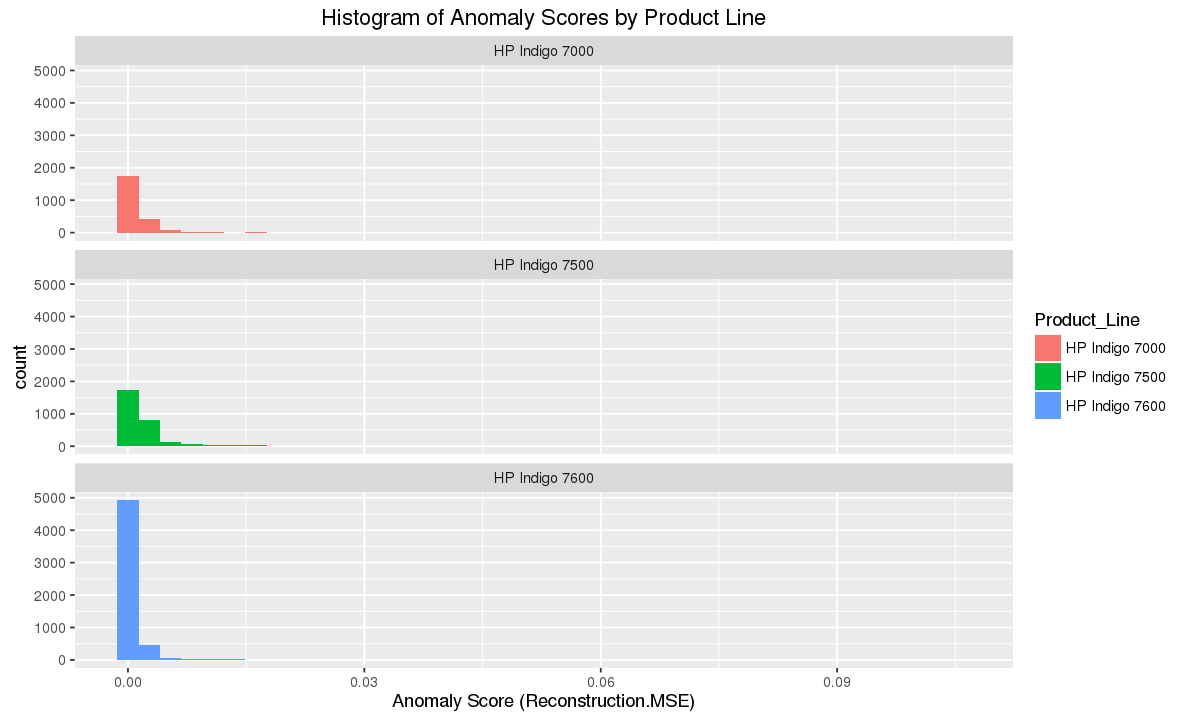

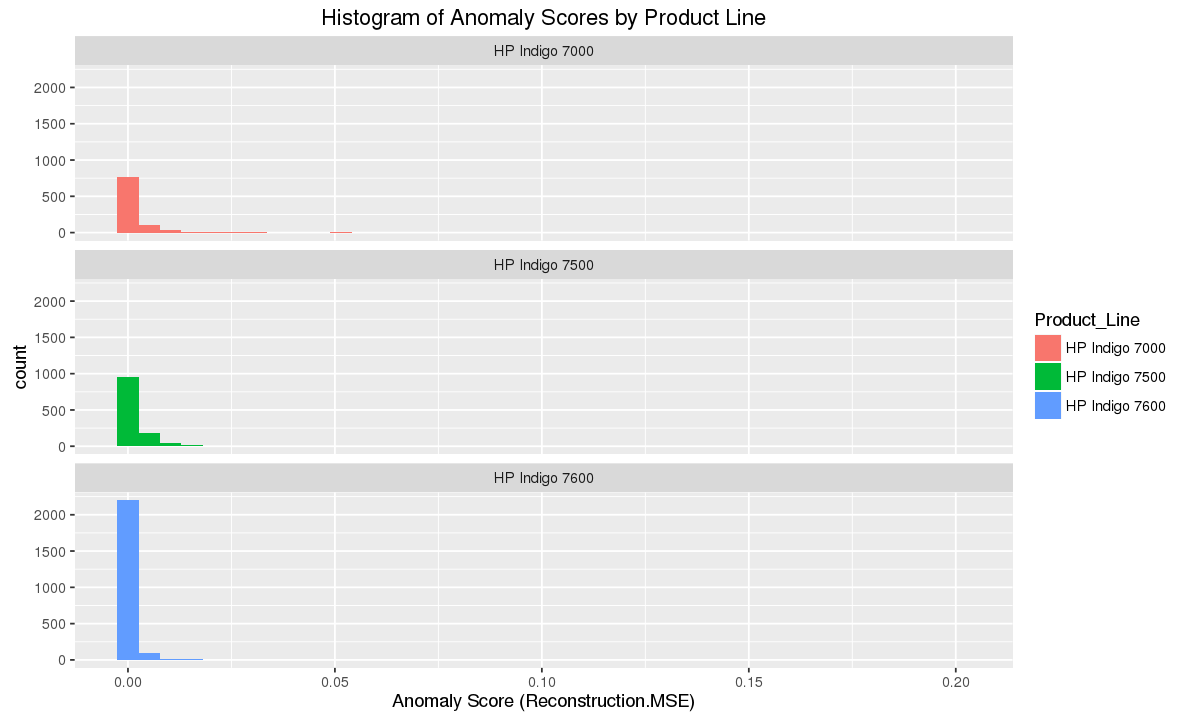

In [38]:
options(repr.plot.width=10, repr.plot.height = 6)
training_anom_all %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  facet_wrap(~Product_Line, nrow = 3) +
                  ggtitle("Histogram of Anomaly Scores by Product Line") +
                  xlab("Anomaly Score (Reconstruction.MSE)")
test_anom_all %>% ggplot(aes(x = Reconstruction.MSE, fill = Product_Line)) +
                  geom_histogram(bins = 40) +
                  facet_wrap(~Product_Line, nrow = 3) +
                  ggtitle("Histogram of Anomaly Scores by Product Line") +
                  xlab("Anomaly Score (Reconstruction.MSE)")

In [39]:
cat("Product Line: All\n")
training_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))


training_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_all %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7000\n")
training_anom_7000 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
training_anom_7000 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7000 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7500\n")
training_anom_7500 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
training_anom_7500 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7500 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7600\n")
training_anom_7600 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
training_anom_7600 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7600 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                           events = sum(n_events))

Product Line: All


n_presses max_anom mean_anom min_anom range_anom events
1       506   0.1056    0.0015    1e-04     0.1055  10718

n_presses max_anom mean_anom min_anom range_anom events
1       161   0.1056    0.0063   0.0025     0.1031   1071

Product Line: HP Indigo 7000


n_presses max_anom mean_anom min_anom range_anom events
1       126   0.1056    0.0018    2e-04     0.1054   2320

n_presses max_anom mean_anom min_anom range_anom events
1        36   0.1056    0.0075   0.0028     0.1028    232

Product Line: HP Indigo 7500


n_presses max_anom mean_anom min_anom range_anom events
1       137   0.0596    0.0024    2e-04     0.0594   2861

n_presses max_anom mean_anom min_anom range_anom events
1        37   0.0596    0.0091   0.0046      0.055    286

Product Line: HP Indigo 7600


n_presses max_anom mean_anom min_anom range_anom events
1       243   0.0481     9e-04    1e-04      0.048   5537

n_presses max_anom mean_anom min_anom range_anom events
1        72   0.0481    0.0046   0.0015     0.0466    553

In [40]:
cat("Product Line: All\n")
test_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))


test_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom_all %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7000\n")
test_anom_7000 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
test_anom_7000 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom_7000 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7500\n")
test_anom_7500 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
test_anom_7500 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom_7500 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))

cat("Product Line: HP Indigo 7600\n")
test_anom_7600 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                            events = sum(n_events))
test_anom_7600 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(test_anom_7600 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(event_press) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  summarise(n_presses = n(),
                            max_anom = round(max(max_anom), 4),
                            mean_anom = round(mean(mean_anom), 4),
                            min_anom = round(min(min_anom), 4),
                            range_anom = round(max_anom - min_anom, 4),
                           events = sum(n_events))

Product Line: All


n_presses max_anom mean_anom min_anom range_anom events
1       412   0.2009    0.0019    1e-04     0.2008   4489

n_presses max_anom mean_anom min_anom range_anom events
1        86   0.2009    0.0103   0.0031     0.1978    448

Product Line: HP Indigo 7000


n_presses max_anom mean_anom min_anom range_anom events
1        89     0.05    0.0025    2e-04     0.0498    943

n_presses max_anom mean_anom min_anom range_anom events
1        19     0.05    0.0149   0.0058     0.0442     94

Product Line: HP Indigo 7500


n_presses max_anom mean_anom min_anom range_anom events
1       116   0.2009     0.003    2e-04     0.2007   1219

n_presses max_anom mean_anom min_anom range_anom events
1        24   0.2009    0.0174   0.0049      0.196    121

Product Line: HP Indigo 7600


n_presses max_anom mean_anom min_anom range_anom events
1       207   0.0276     0.001    1e-04     0.0275   2327

n_presses max_anom mean_anom min_anom range_anom events
1        56   0.0276    0.0044   0.0018     0.0258    232

In [41]:
cat("All anomalous events by product line\n")
training_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))

cat("10% of most anomalous events with product lines combined separated by product line\n")
training_anom_all %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_all %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))

cat("10% of most anomalous events with product lines separated\n")
training_anom_7000 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7000 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))


training_anom_7500 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7500 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))


training_anom_7600 %>% arrange(desc(Reconstruction.MSE)) %>%
                  #Select the 10% more anomalous entries
                  head(training_anom_7600 %>% nrow()/10) %>% 
                  #Grouping by press, summarise the anomaly score
                  group_by(Product_Line) %>% 
                  summarise(max_anom = round(max(Reconstruction.MSE), 4),
                            min_anom = round(min(Reconstruction.MSE), 4),
                            mean_anom = round(mean(Reconstruction.MSE), 4),
                            median_anom = round(median(Reconstruction.MSE), 4),
                            sd_anom = round(sd(Reconstruction.MSE), 4),
                            n_events = n()) %>%
                  arrange(desc(max_anom), desc(n_events))

All anomalous events by product line


Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7000   0.1056    2e-04    0.0016      0.0009  0.0037     2320
2 HP Indigo 7500   0.0596    2e-04    0.0022      0.0011  0.0036     2861
3 HP Indigo 7600   0.0481    1e-04    0.0009      0.0004  0.0025     5537

10% of most anomalous events with product lines combined separated by product line


Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7000   0.1056   0.0026    0.0071      0.0043  0.0094      262
2 HP Indigo 7500   0.0596   0.0025    0.0072      0.0049  0.0061      538
3 HP Indigo 7600   0.0481   0.0026    0.0084      0.0052  0.0084      271

10% of most anomalous events with product lines separated


Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7000   0.1056   0.0028    0.0077      0.0046  0.0099      232

Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7500   0.0596   0.0046    0.0106      0.0088  0.0067      286

Product_Line max_anom min_anom mean_anom median_anom sd_anom n_events
1 HP Indigo 7600   0.0481   0.0015    0.0051      0.0025  0.0067      553

By separating the data set into different training sets and then selecting the 10% most anomalous out of all events we see that HP Indigo 7500 berelly has any events in this arbritary anomalous range, as we see in the Histograms above.

By taking the 10% most anomalous events per product line, however, we see why HP Indigo 7500 has so few events when compared together.

# Clustering Anomaly Results

The following information is based on the clValid description:

### Internal Validation

The internal measures include the connectivity, and Silhouette Width, and Dunn Index. The connectivity indicates the degree of connectedness of the clusters, as determined by the k-nearest neighbors. The connectivity has a value between 0 and infinity and should be minimized. Both the Silhouette Width and the Dunn Index combine measures of compactness and separation of the clusters. The Silhouette Width is the average of each observation's Silhouette value. The Silhouette value measures the degree of confidence in a particular clustering assignment and lies in the interval [-1,1], with well-clustered observations having values near 1 and poorly clustered observations having values near -1. The Dunn Index is the ratio between the smallest distance between observations not in the same cluster to the largest intra-cluster distance. It has a value between 0 and infinity and should be maximized.


In [42]:
library(clValid)
library(factoextra)

Loading required package: cluster


## Clustering data for all product line model
We attempt to analyze clustering propensity of the training data itself, as well as the most anomalous events based on the trained model. We want to see whether the anomalous events cluster in different ways than the whole data.

In [43]:
cluster_validation  <- training_data %>%
                        select(6:186) %>% as.data.frame() %>%
                        clValid(2:10, clMethods = "kmeans", 
                                validation = "internal", maxitems = nrow(training_data))

summary(cluster_validation)
optimalScores(cluster_validation)


Clustering Methods:
 kmeans 

Cluster sizes:
 2 3 4 5 6 7 8 9 10 

Validation Measures:
                            2        3        4        5        6        7        8        9       10
                                                                                                     
kmeans Connectivity   17.5282 112.4964 350.2294 444.1722 620.6770 546.7837 742.1706 913.3726 917.9710
       Dunn            0.0366   0.0121   0.0156   0.0156   0.0125   0.0094   0.0156   0.0169   0.0133
       Silhouette      0.7284   0.6917   0.4786   0.4225   0.4599   0.3903   0.3940   0.3536   0.4060

Optimal Scores:

             Score   Method Clusters
Connectivity 17.5282 kmeans 2       
Dunn          0.0366 kmeans 2       
Silhouette    0.7284 kmeans 2       



Score Method Clusters
Connectivity 17.52817460 kmeans        2
Dunn          0.03659176 kmeans        2
Silhouette    0.72840801 kmeans        2

Based on the above description of internal validation, we can see that Silhouette score is close to 1, which means it poorly defined clusters. Dunn's index also shows poor clusterization.

In [45]:
training_most_anom <- training_anom %>% arrange(desc(Reconstruction.MSE)) %>%
                      #Select the 10% more anomalous entries
                      head(training_anom %>% nrow()/10)

cluster_validation_anom <- training_most_anom %>%
                        select(6:186) %>% as.data.frame() %>%
                        clValid(2:10, clMethods = "kmeans", 
                                validation = "internal", maxitems = nrow(training_most_anom))

summary(cluster_validation_anom)
optimalScores(cluster_validation_anom)


Clustering Methods:
 kmeans 

Cluster sizes:
 2 3 4 5 6 7 8 9 10 

Validation Measures:
                            2        3        4        5        6        7        8        9       10
                                                                                                     
kmeans Connectivity    3.5861   4.2079   7.2976  14.1024 115.9917 121.3750 138.3528 157.6429 161.9563
       Dunn            0.0859   0.0913   0.1739   0.1739   0.0293   0.0293   0.0354   0.0370   0.0371
       Silhouette      0.8318   0.7960   0.7905   0.7660   0.4153   0.4147   0.3592   0.3305   0.3567

Optimal Scores:

             Score  Method Clusters
Connectivity 3.5861 kmeans 2       
Dunn         0.1739 kmeans 4       
Silhouette   0.8318 kmeans 2       



Score Method Clusters
Connectivity 3.5861111 kmeans        2
Dunn         0.1739301 kmeans        4
Silhouette   0.8318168 kmeans        2

The most anomalous events do not show good clusterization metrics. While the number of clusters suggested by the Dunn's index is 4, the value is rather small to be confident. Despite that we can attempt to see how bad is the clustering for the suggested 4 clusters.

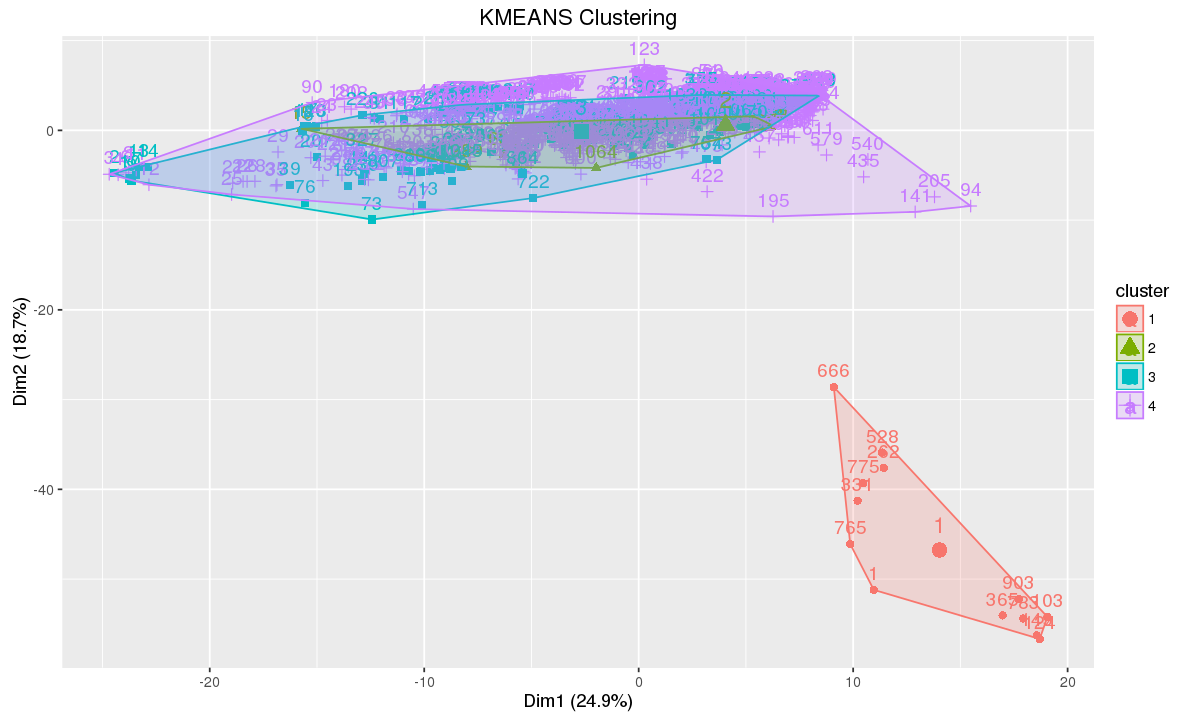

In [54]:
optimal_cluster_size <- 4

training_most_data_km <- training_most_anom %>%
                    select(6:186) %>% as.data.frame() %>%
                    eclust("kmeans", k = optimal_cluster_size, nstart = 150)


The visualiztion using PCA means that Dim1 and Dim2 constitute 43.6% of the variance, and it shows a small cluster of events on the right bottom quadrant, the other clusters are on top of each others confirming the values we see for internal validation.